# Index
<ol>
    <li><a href="#setup_and_data_download">Setup and data download</a>
    <li><a href="#training_data_visualization">Training data visualization</a>
    <li><a href="#data_cleaning_and_feature_engineering">Feature engineering</a>
    <li><a href="#model_validation">Data preprocessing</a>
    <li><a href="#model_training">Model training</a>
    <li><a href="#model_predictions">Model predictions</a>
       
           
            

<br>
<br>
<a id="setup_and_data_download"> </a>
# 1. Setup and data download

<br>
## 1.1 Libraries setup

### Import the fastai library

In [514]:
from fastai.imports import *
from fastai.transforms import *
import fastai.conv_learner
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.structured import *
from fastai.column_data import *

### Import functionality libraries

In [515]:
import os # Create directories, list files
import zipfile # Extract compressed files
import numpy as np # Linear algebra, sorting and selecting
import pandas as pd # Dataframes and csv I/O
import matplotlib.pyplot as plt # Plotting histograms
from PIL import Image # Python Image Library, get sizes from images
from collections import Counter # Class for counting purposes
from math import exp # Exponential function
from sklearn.metrics import classification_report, precision_recall_fscore_support, fbeta_score ,roc_auc_score, roc_curve, auc # Useful metrics for single label classification
import time # Measuring elapsed time
import itertools as it
from torch import FloatTensor
import torch
from torch.nn import *
from functools import reduce

### Check CUDA is enabled

It's important that you have a working Nvidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA.

In [516]:
torch.cuda.is_available()

True

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN

In [517]:
torch.backends.cudnn.enabled

True

<br>
## 1.2 Enviroment setup

### Environment

The environment overview

```
./input
│      
│
└─── train
│   │   application_train.csv
│   │   bureau.csv
|   │   bureau_balance.csv
│   │   credit_card_balance.csv
|   │   installments_payments.csv
│   │   POS_CASH_balance.csv
|   │   previous_application.csv
│
└─── test
│   │   application_test.csv
│   
└─── submission
    │   sample_submission.csv
    │   submission1.csv
```

### Windows or Unix
Set the separators depending on the OS

In [518]:
OS = "Linux"

In [519]:
if OS == "Windows":
    s = "\\"
elif OS == "Linux":
    s = "/"
else:
    print("Not a valid OS")

### Initialize the environment variables

In [520]:
TRAIN_DIR = "train"
TEST_DIR = "test"
SUBMISSION_DIR = "submission"
INPUT_PATH = f'.{s}input'
TRAIN_PATH = f'{INPUT_PATH}{s}{TRAIN_DIR}'
TEST_PATH = f'{INPUT_PATH}{s}{TEST_DIR}'
SUBMISSION_PATH = f'{INPUT_PATH}{s}{SUBMISSION_DIR}'
DOWNLOAD_PATH = "C:\\Users\\David\\.kaggle\\competitions\\home-credit-default-risk"

<br>
## 1.2 Data setup

### Download the data from kaggle

Instructions to use the kaggle API: https://github.com/Kaggle/kaggle-api <br>
Remember to accept the rules of the competition, otherwise it won't work.

In [521]:
download_all_data = False

In [522]:
if download_all_data:
    os.system(f'kaggle competitions download -c home-credit-default-risk')
    print("Compressed files ready")

### Create the input directory

In [523]:
if not os.path.exists(f'{INPUT_PATH}'):
    os.mkdir(f'{INPUT_PATH}')

### Check download directory

Check the download directory.<br>
As we can see, we have a bunch of csv files containing data.

In [524]:
os.listdir(DOWNLOAD_PATH)

['application_test.csv.zip',
 'application_train.csv.zip',
 'bureau.csv.zip',
 'bureau_balance.csv.zip',
 'credit_card_balance.csv.zip',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv.zip',
 'POS_CASH_balance.csv.zip',
 'previous_application.csv.zip',
 'sample_submission.csv.zip']

### Create the train, test and submission directory

In [525]:
if not os.path.exists(TRAIN_PATH): 
    os.mkdir(TRAIN_PATH)
print("Train directory ready")

if not os.path.exists(TEST_PATH): 
    os.mkdir(TEST_PATH)
print("Test directory ready")

if not os.path.exists(SUBMISSION_PATH): 
    os.mkdir(SUBMISSION_PATH)
print("Submmission directory ready")

Train directory ready
Test directory ready
Submmission directory ready


### Extract the data

Extract the data in the train directory and submission directory.<br>
Set the flag to false when already extracted.

In [526]:
extract_data = False

In [527]:
train_csv_files = ["application_train.csv.zip", "bureau.csv.zip", "credit_card_balance.csv.zip", 
                   'installments_payments.csv.zip', 
                   'POS_CASH_balance.csv.zip', 'previous_application.csv.zip',]
test_csv_files = ["application_test.csv.zip"]
submission_csv_files = ['sample_submission.csv.zip']

In [528]:
if extract_data:
    for csv_file in train_csv_files:
        csv_zip = zipfile.ZipFile(f'{DOWNLOAD_PATH}{s}{csv_file}', mode="r")
        csv_zip.extractall(TRAIN_PATH)
        csv_zip.close()
    for csv_file in test_csv_files:
        csv_zip = zipfile.ZipFile(f'{DOWNLOAD_PATH}{s}{csv_file}', mode="r")
        csv_zip.extractall(TEST_PATH)
        csv_zip.close()

    for csv_file in submission_csv_files:
        csv_zip = zipfile.ZipFile(f'{DOWNLOAD_PATH}{s}{csv_file}', mode="r")
        csv_zip.extractall(SUBMISSION_PATH)
        csv_zip.close()

print("All files ready")

All files ready


### Check environment is correctly initialized

In [529]:
expected_dir = [TRAIN_DIR,  TEST_DIR, SUBMISSION_DIR]
current_dir = os.listdir(INPUT_PATH)
print(current_dir)
if set(expected_dir).issubset(set(current_dir)): print("Everything is correct")

['submission', 'test', 'test_general_df', 'train', 'train_general_df']
Everything is correct


<br>
<br>
<a id="data_preprocessing"> </a>
# 2. Training data visualization
Create a flag to iterate faster if we have a working model.

In [530]:
visualization = True

<br>
## 2.1 Generate the dataframes

Extract the names of the csv files in the train folder.<br>


In [531]:
train_table_names = [train_table_name[:-4] for train_table_name in os.listdir(TRAIN_PATH) if train_table_name[-4:] == ".csv"]
test_table_names = [test_table_name[:-4] for test_table_name in os.listdir(TEST_PATH) if test_table_name[-4:] == ".csv"]
print(train_table_names)
print(test_table_names)

['application_train', 'bureau', 'credit_card_balance', 'HomeCredit_columns_description', 'installments_payments', 'POS_CASH_balance', 'previous_application']
['application_test']


To iterate faster we define a maximum sample_size (to train on the full dataset set it to None).

In [532]:
sample_size = 10000

Create the dictionary that links each name to the corresponging dataframe.<br>

In [533]:
generate_datasets = True

In [534]:
if generate_datasets:
    train_tables_dict = {train_table_name : pd.read_csv(f'{TRAIN_PATH}{s}{train_table_name}.csv', nrows=sample_size, low_memory=False, encoding= "ISO-8859-1") for train_table_name in train_table_names}
    test_tables_dict = {test_table_name : pd.read_csv(f'{TEST_PATH}{s}{test_table_name}.csv', nrows=sample_size, low_memory=False, encoding= "ISO-8859-1") for test_table_name in test_table_names}

<br><br>
## 2.2 Preliminary dataframes exploration

### Data description

In [535]:
columns_description_df = pd.read_csv(f'{TRAIN_PATH}{s}HomeCredit_columns_description.csv', low_memory=False, encoding= "ISO-8859-1")

In [536]:
columns_description_df

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


In [537]:
if visualization:
    train_tables_dict["application_train"]['AMT_INCOME_TOTAL'].unique()

In [538]:
if visualization:
    train_tables_dict["application_train"]['CNT_CHILDREN'].unique()

<br>
### Application train dataframe

In [539]:
if visualization:
    train_tables_dict["application_train"].info()
    display(train_tables_dict["application_train"].columns.values)
    display(train_tables_dict["application_train"].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 9.3+ MB


array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
   

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Let's analyze the elements of the train dataframe:<br>
<ol>
    <li><b>SK_ID_CURR</b>: An identifier of the loan requested.<br>
        This is the main index column
    </li><br>
    <li><b>TARGET</b>: Target variable, difficulties paying the loan (1), anything else (0)
    </li><br>
    <li><b>NAME_CONTRACT_TYPE</b>: Loan in one payment of cash or revolving
    </li><br>
    <li><b>CODE_GENDER</b>: Gender of the client
    </li><br>
    <li><b>FLAG_OWN_CAR</b>: Owns car
    </li><br>
    <li><b>FLAG_OWN_REALTY</b>: Owns flat or house.
    </li><br>
    <li><b>CNT_CHILDREN</b>: How many children the owner has
    </li><br>
    <li><b>AMT_INCOME_TOTAL</b>: Income of the client
    </li><br>
    <li><b>AMT_CREDIT</b>: Amount of cash requested
    </li><br>
    <li><b>AMT_ANNUITY</b>: Amount to pay in a period of time
    </li><br>
    <li><b>AMT_GOODS_PRICE</b>: Price of the goods for which the loan is given
    </li><br>
</ol>

<br>
### Bureau dataframe


In [540]:

train_tables_dict["bureau"].head()
asd = train_tables_dict["bureau"].groupby("SK_ID_CURR").agg({"DAYS_CREDIT": [np.mean, np.std, len ]})
asd["DAYS_CREDIT"].rename(columns={'mean':'DAYS_CREDIT_MEAN'})

,DAYS_CREDIT_MEAN,std,len
SK_ID_CURR,,,
100053,-2287.714286,470.728412,7
100568,-493.857143,369.824025,7
100653,-1237.571429,993.205896,7
100802,-525.000000,NaN,1
100819,-917.555556,577.079791,18
100915,-362.000000,NaN,1
101060,-1328.500000,882.613732,4
101133,-2385.000000,NaN,1
101562,-1228.285714,349.765500,7


We need to obtain a single metric from all the previous loans. We can use 

<br>
### Credit card balance

In [541]:
if visualization:
    train_tables_dict["credit_card_balance"].info()
    display(train_tables_dict["credit_card_balance"].columns.values)
    display(train_tables_dict["credit_card_balance"].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
SK_ID_PREV                    10000 non-null int64
SK_ID_CURR                    10000 non-null int64
MONTHS_BALANCE                10000 non-null int64
AMT_BALANCE                   10000 non-null float64
AMT_CREDIT_LIMIT_ACTUAL       10000 non-null int64
AMT_DRAWINGS_ATM_CURRENT      7933 non-null float64
AMT_DRAWINGS_CURRENT          10000 non-null float64
AMT_DRAWINGS_OTHER_CURRENT    7933 non-null float64
AMT_DRAWINGS_POS_CURRENT      7933 non-null float64
AMT_INST_MIN_REGULARITY       9674 non-null float64
AMT_PAYMENT_CURRENT           7952 non-null float64
AMT_PAYMENT_TOTAL_CURRENT     10000 non-null float64
AMT_RECEIVABLE_PRINCIPAL      10000 non-null float64
AMT_RECIVABLE                 10000 non-null float64
AMT_TOTAL_RECEIVABLE          10000 non-null float64
CNT_DRAWINGS_ATM_CURRENT      7933 non-null float64
CNT_DRAWINGS_CURRENT          10000 non-null int64
CNT_DRA

array(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL',
       'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT',
       'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT',
       'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'], dtype=object)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


<br>
### Installments payments

In [542]:
if visualization:
    train_tables_dict["installments_payments"].info()
    display(train_tables_dict["installments_payments"].columns.values)
    display(train_tables_dict["installments_payments"].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
SK_ID_PREV                10000 non-null int64
SK_ID_CURR                10000 non-null int64
NUM_INSTALMENT_VERSION    10000 non-null float64
NUM_INSTALMENT_NUMBER     10000 non-null int64
DAYS_INSTALMENT           10000 non-null float64
DAYS_ENTRY_PAYMENT        10000 non-null float64
AMT_INSTALMENT            10000 non-null float64
AMT_PAYMENT               10000 non-null float64
dtypes: float64(5), int64(3)
memory usage: 625.1 KB


array(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT',
       'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT'], dtype=object)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


<br>
### Pos cash balance

In [543]:
if visualization:
    train_tables_dict["POS_CASH_balance"].info()
    display(train_tables_dict["POS_CASH_balance"].columns.values)
    display(train_tables_dict["POS_CASH_balance"].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
SK_ID_PREV               10000 non-null int64
SK_ID_CURR               10000 non-null int64
MONTHS_BALANCE           10000 non-null int64
CNT_INSTALMENT           9986 non-null float64
CNT_INSTALMENT_FUTURE    9986 non-null float64
NAME_CONTRACT_STATUS     10000 non-null object
SK_DPD                   10000 non-null int64
SK_DPD_DEF               10000 non-null int64
dtypes: float64(2), int64(5), object(1)
memory usage: 625.1+ KB


array(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE',
       'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF'], dtype=object)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


<br>
### Previous application

In [544]:
if visualization:
    train_tables_dict["previous_application"].info()
    display(train_tables_dict["previous_application"].columns.values)
    display(train_tables_dict["previous_application"].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 37 columns):
SK_ID_PREV                     10000 non-null int64
SK_ID_CURR                     10000 non-null int64
NAME_CONTRACT_TYPE             10000 non-null object
AMT_ANNUITY                    7915 non-null float64
AMT_APPLICATION                10000 non-null float64
AMT_CREDIT                     10000 non-null float64
AMT_DOWN_PAYMENT               4954 non-null float64
AMT_GOODS_PRICE                7878 non-null float64
WEEKDAY_APPR_PROCESS_START     10000 non-null object
HOUR_APPR_PROCESS_START        10000 non-null int64
FLAG_LAST_APPL_PER_CONTRACT    10000 non-null object
NFLAG_LAST_APPL_IN_DAY         10000 non-null int64
RATE_DOWN_PAYMENT              4954 non-null float64
RATE_INTEREST_PRIMARY          37 non-null float64
RATE_INTEREST_PRIVILEGED       37 non-null float64
NAME_CASH_LOAN_PURPOSE         10000 non-null object
NAME_CONTRACT_STATUS           10000 non-null obje

array(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT',
       'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'DAYS_DECISION',
       'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'SELLERPLACE_AREA',
       'NAME_SELLER_INDUSTRY', 'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE',
       'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'], dtype=object)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


<br><br>
# 3. Feature engineering
Create a flag to iterate faster if we have a working model.

In [545]:
feature_engineering = True

<br>
### Bureau dataframe
Bureau dataframe shows information about previous loans from other finantial entities.<br>
Because each current identifier has multiple entires, we have to group the information by such identifiers and then apply functions to extract aggregate metrics.

In [546]:
train_tables_dict["bureau"].info()
display(train_tables_dict["bureau"].columns.values)
display(train_tables_dict["bureau"].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
SK_ID_CURR                10000 non-null int64
SK_ID_BUREAU              10000 non-null int64
CREDIT_ACTIVE             10000 non-null object
CREDIT_CURRENCY           10000 non-null object
DAYS_CREDIT               10000 non-null int64
CREDIT_DAY_OVERDUE        10000 non-null int64
DAYS_CREDIT_ENDDATE       9369 non-null float64
DAYS_ENDDATE_FACT         6229 non-null float64
AMT_CREDIT_MAX_OVERDUE    3595 non-null float64
CNT_CREDIT_PROLONG        10000 non-null int64
AMT_CREDIT_SUM            10000 non-null float64
AMT_CREDIT_SUM_DEBT       8460 non-null float64
AMT_CREDIT_SUM_LIMIT      6550 non-null float64
AMT_CREDIT_SUM_OVERDUE    10000 non-null float64
CREDIT_TYPE               10000 non-null object
DAYS_CREDIT_UPDATE        10000 non-null int64
AMT_ANNUITY               1834 non-null float64
dtypes: float64(8), int64(6), object(3)
memory usage: 1.3+ MB


array(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
       'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE',
       'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY'], dtype=object)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


### Bureau: Credit active
Credit active represents if the previous credits still has to be payed or not.<br>
We will extract two metrics:
<ol>
    <li>The number of credits requested</li>
    <li>The percentage of active credits</li>

In [547]:
def active_percentage(array):
    freq_dict = Counter(array)
    return freq_dict["Active"]/len(array)

In [548]:
credit_active = train_tables_dict["bureau"].groupby("SK_ID_CURR").agg({'CREDIT_ACTIVE': [len,
                                                                       active_percentage]
                                                     })

credit_active.columns = credit_active.columns.droplevel()
credit_active = credit_active.rename(index=str, columns={"len" : "N_PREVIOUS_CREDITS",
                                                         "active_percentage" : "PREVIOUS_ACTIVE_CREDITS"})
credit_active.head()

,N_PREVIOUS_CREDITS,PREVIOUS_ACTIVE_CREDITS
SK_ID_CURR,,
100053,7,0.142857
100568,7,0.428571
100653,7,0.571429
100802,1,1.000000
100819,18,0.333333


### Bureau: Credit currency
Credit currency represents the currency of the previous loans.<br>
We will extract two metrics:
<ol>
    <li>The number of currencies requested</li>
    <li>The most requested currency</li>

In [549]:
def n_unique_currencies(array):
    return  len(array.unique())

In [550]:
def most_used_currency(array):
    freq_dict = Counter(array)
    items = list(freq_dict.items())
    most_used_currency = max(items, key=lambda item: item[1])
    return most_used_currency[0]

In [551]:
credit_currency = train_tables_dict["bureau"].groupby("SK_ID_CURR").agg({'CREDIT_CURRENCY': [n_unique_currencies, most_used_currency]
                                                     })

credit_currency.columns = credit_currency.columns.droplevel()
credit_currency = credit_currency.rename(index=str, columns={"most_used_currency" : "MOST_USED_CURRENCY",
                                                             "n_unique_currencies" : "N_UNIQUE_CURRENCIES"
                                                            })
credit_currency.head()

,N_UNIQUE_CURRENCIES,MOST_USED_CURRENCY
SK_ID_CURR,,
100053,1,currency 1
100568,1,currency 1
100653,1,currency 1
100802,1,currency 1
100819,1,currency 1


### Bureau: Days credit
Days credit represents the number of days since that loan was requested.<br>
We will extract two metrics:
<ol>
    <li>Average time between credits</li>
    <li>Last credit time</li>

In [552]:
def avg_time_between_credits(array):
    sorted_array = array.sort_values().values
    periods = [sorted_array[i+1] - sorted_array[i] for i in range(len(sorted_array)-1)]
    try:
        avg = sum(periods)/len(periods)
    except ZeroDivisionError:
        avg = None
    return avg

In [553]:
def days_since_last_credit(array):
    return abs(max(array.values))

In [554]:
days_credit = train_tables_dict["bureau"].groupby("SK_ID_CURR").agg({'DAYS_CREDIT': [avg_time_between_credits,
                                                                                     days_since_last_credit]
                                                     })

days_credit.columns = days_credit.columns.droplevel()
days_credit = days_credit.rename(index=str, columns={"avg_time_between_credits" : "AVG_TIME_BETWEEN_CREDITS",
                                                     "days_since_last_credit" : "DAYS_SINCE_LAST_CREDIT"
                                                    })
days_credit["AVG_TIME_BETWEEN_CREDITS"] = days_credit["AVG_TIME_BETWEEN_CREDITS"].fillna(9999)
days_credit["DAYS_SINCE_LAST_CREDIT"] = days_credit["DAYS_SINCE_LAST_CREDIT"].fillna(9999)
days_credit = days_credit.round(2)
days_credit.head()

,AVG_TIME_BETWEEN_CREDITS,DAYS_SINCE_LAST_CREDIT
SK_ID_CURR,,
100053,188.17,1764
100568,177.83,207
100653,382.00,182
100802,9999.00,525
100819,107.88,262


In [555]:
max(days_credit["AVG_TIME_BETWEEN_CREDITS"].values)

9999.0

In [556]:
days_credit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2011 entries, 100053 to 456116
Data columns (total 2 columns):
AVG_TIME_BETWEEN_CREDITS    2011 non-null float64
DAYS_SINCE_LAST_CREDIT      2011 non-null int64
dtypes: float64(1), int64(1)
memory usage: 47.1+ KB


In [611]:
np.finfo(np.float32).max

3.4028235e+38

### Bureau: Credit days overdue
Credits days overdue represent the number of overdue days for each credit.<br>
We will extract three metrics:
<ol>
    <li>Average overdue</li>
    <li>Number of overdue</li>
    <li>Percentage risk of overdue</li>
    <li>Max overdue</li>

In [557]:
def avg_overdue(array):
    try:
        avg = sum(array)/len(array)
    except ZeroDivisionError:
        avg = None
    return avg

In [558]:
def n_overdue(array):
    return  sum(i>0 for i in array)

In [559]:
def percentage_risk_overdue(array):
    return  sum(i>0 for i in array)/len(array)

In [560]:
def max_overdue(array):
    return  max(array)

In [561]:
credit_day_overdue = train_tables_dict["bureau"].groupby("SK_ID_CURR").agg({'CREDIT_DAY_OVERDUE': [avg_overdue,
                                                                                                   n_overdue,
                                                                                                   percentage_risk_overdue,
                                                                                                   max_overdue]
                                                     })

credit_day_overdue.columns = credit_day_overdue.columns.droplevel()
credit_day_overdue = credit_day_overdue.rename(index=str, columns={"avg_overdue" : "AVG_OVERDUE",
                                                                   "n_overdue" : "N_OVERDUE",
                                                                   "percentage_risk_overdue" : "PERCENTAGE_RISK_OVERDUE",
                                                                   "max_overdue" : "MAX_OVERDUE"
                                                            })
credit_day_overdue.head()

,AVG_OVERDUE,N_OVERDUE,PERCENTAGE_RISK_OVERDUE,MAX_OVERDUE
SK_ID_CURR,,,,
100053,0.0,0,0.0,0
100568,0.0,0,0.0,0
100653,0.0,0,0.0,0
100802,0.0,0,0.0,0
100819,0.0,0,0.0,0


### Bureau: Credit days enddate
Credits days enddate represent the remaining days of credit:<br>
We will extract two metrics:
<ol>
    <li>Total remaining days</li>
    <li>Number of credits remaining</li>


In [562]:
def avg_remaining_days(array):
    try:
        array = array[array >= 0]
        avg = sum(array)/len(array)
    except ZeroDivisionError:
        avg = None
    return avg

In [563]:
def max_(array):
    return  sum(i>0 for i in array)

In [564]:
credit_days_enddate = train_tables_dict["bureau"].groupby("SK_ID_CURR").agg({'DAYS_CREDIT_ENDDATE': [avg_remaining_days,
                                                                                                     n_active_credits,
                                                                                                   ]
                                                     })

credit_days_enddate.columns = credit_days_enddate.columns.droplevel()
credit_days_enddate = credit_days_enddate.rename(index=str, columns={"avg_remaining_days" : "AVG_REMAINING_DAYS",
                                                                   "n_active_credits" : "N_ACTIVE_CREDITS",
                                                            })
credit_days_enddate.head()

,AVG_REMAINING_DAYS,N_ACTIVE_CREDITS
SK_ID_CURR,,
100053,NaN,0.0
100568,1044.5,2.0
100653,1755.0,2.0
100802,928.0,1.0
100819,768.8,5.0


### Bureau: Days enddate fact
How many days since the credit ended:<br>
We will extract 0 metrics:


### Bureau: Amount credit max overdue
Max overdue for a credit:<br>
We will extract two metrics:
<ol>
    <li>Max overdue</li>
    <li>Average overdue</li>


In [565]:
def credit_avg_overdue(array):
    try:
        array=np.nan_to_num(array, 0)
        avg = sum(array)/len(array)
    except ZeroDivisionError:
        avg = 0
    return avg

In [566]:
def credit_max_overdue(array):
    array=np.nan_to_num(array, 0)
    return  max(array)

In [567]:
amnt_credit_max_overdue = train_tables_dict["bureau"].groupby("SK_ID_CURR").agg({'AMT_CREDIT_MAX_OVERDUE': [credit_avg_overdue,
                                                                                                     credit_max_overdue,
                                                                                                   ]
                                                     })

amnt_credit_max_overdue.columns = amnt_credit_max_overdue.columns.droplevel()
amnt_credit_max_overdue = amnt_credit_max_overdue.rename(index=str, columns={"credit_avg_overdue" : "CREDIT_AVG_OVERDUE",
                                                                   "credit_max_overdue" : "CREDIT_MAX_OVERDUE",
                                                            })
amnt_credit_max_overdue.head()

,CREDIT_AVG_OVERDUE,CREDIT_MAX_OVERDUE
SK_ID_CURR,,
100053,0.000000,0.000
100568,1168.412143,8178.885
100653,0.000000,0.000
100802,0.000000,0.000
100819,0.000000,0.000


### Bureau: Credit prolong
How many times was the credit prolonged:<br>
We will extract two metrics:
<ol>
    <li>Average prolonged</li>
    <li>Max prolonged</li>


In [568]:
def avg_prolong(array):
    try:
        array=np.nan_to_num(array, 0)
        avg = sum(array)/len(array)
    except ZeroDivisionError:
        avg = 0
    return avg

In [569]:
def max_prolong(array):
    array=np.nan_to_num(array, 0)
    return  max(array)

In [570]:
credit_prolong = train_tables_dict["bureau"].groupby("SK_ID_CURR").agg({'CNT_CREDIT_PROLONG': [avg_prolong,
                                                                                                     max_prolong,
                                                                                                   ]
                                                     })

credit_prolong.columns = credit_prolong.columns.droplevel()
credit_prolong = credit_prolong.rename(index=str, columns={"avg_prolong" : "AVG_PROLONG",
                                                                   "max_prolong" : "MAX_PROLONG",
                                                            })
credit_prolong.head()

,AVG_PROLONG,MAX_PROLONG
SK_ID_CURR,,
100053,0.0,0
100568,0.0,0
100653,0.0,0
100802,0.0,0
100819,0.0,0


<br>
### Bureau processed dataframe
Merge all the aggregated dataframes

In [571]:
bureau_aggregated_df = [credit_active, credit_currency, days_credit, credit_day_overdue, credit_days_enddate,
                       amnt_credit_max_overdue, credit_prolong]

In [572]:
for i, df in enumerate(bureau_aggregated_df):
    bureau_aggregated_df[i] = df.reset_index()

In [573]:
bureau_preprocessed_df = reduce(lambda left,right: pd.merge(left,right,on='SK_ID_CURR'), bureau_aggregated_df)

In [574]:
bureau_preprocessed_df.head()

,SK_ID_CURR,N_PREVIOUS_CREDITS,PREVIOUS_ACTIVE_CREDITS,N_UNIQUE_CURRENCIES,MOST_USED_CURRENCY,AVG_TIME_BETWEEN_CREDITS,DAYS_SINCE_LAST_CREDIT,AVG_OVERDUE,N_OVERDUE,PERCENTAGE_RISK_OVERDUE,MAX_OVERDUE,AVG_REMAINING_DAYS,N_ACTIVE_CREDITS,CREDIT_AVG_OVERDUE,CREDIT_MAX_OVERDUE,AVG_PROLONG,MAX_PROLONG
0,100053,7,0.142857,1,currency 1,188.17,1764,0.0,0,0.0,0,NaN,0.0,0.000000,0.000,0.0,0
1,100568,7,0.428571,1,currency 1,177.83,207,0.0,0,0.0,0,1044.5,2.0,1168.412143,8178.885,0.0,0
2,100653,7,0.571429,1,currency 1,382.00,182,0.0,0,0.0,0,1755.0,2.0,0.000000,0.000,0.0,0
3,100802,1,1.000000,1,currency 1,9999.00,525,0.0,0,0.0,0,928.0,1.0,0.000000,0.000,0.0,0
4,100819,18,0.333333,1,currency 1,107.88,262,0.0,0,0.0,0,768.8,5.0,0.000000,0.000,0.0,0


<br><br>
## 2.2 Dataframes merge
Generate the general dataframe that will contain all the relevant information.<br>
To do so we need to find the relations (dates, identifiers) to link all the tables together.<br>
We will start with the most important tables and left merge all the additional information.

### Train and periods train merge
Link the train and periods train tables by the item_id identifier present in both tables.<br>
Because both tables have the activation_date column, we will eliminate the one in the periods_train table.

<b>Train dataframe

In [575]:
if feature_engineering:
    train_general_df = pd.merge(train_tables_dict["application_train"], bureau_preprocessed_df,how="left", on="SK_ID_CURR")

In [576]:
train_general_df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AVG_OVERDUE,N_OVERDUE,PERCENTAGE_RISK_OVERDUE,MAX_OVERDUE,AVG_REMAINING_DAYS,N_ACTIVE_CREDITS,CREDIT_AVG_OVERDUE,CREDIT_MAX_OVERDUE,AVG_PROLONG,MAX_PROLONG
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.000,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.000,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,100008,0,Cash loans,M,N,Y,0,99000.000,490495.5,27517.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,100009,0,Cash loans,F,Y,Y,1,171000.000,1560726.0,41301.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,100010,0,Cash loans,M,Y,Y,0,360000.000,1530000.0,42075.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,100011,0,Cash loans,F,N,Y,0,112500.000,1019610.0,33826.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,100012,0,Revolving loans,M,N,Y,0,135000.000,405000.0,20250.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<b>Test dataframe

In [577]:
if feature_engineering:
    test_general_df = pd.merge(test_tables_dict["application_test"], bureau_preprocessed_df, how="left", on="SK_ID_CURR")

<br>
### Dataframe checkpoint
When working with huge datasets some operations are quite time consuming.<br>
Pandas offers some shortcuts to optimize performance as much as possible.<br>
To feather basically dumps the dataframe representation in RAM as a file. This allows us to rapidly load it later.

<b>Save

In [578]:
save = True

In [579]:
if save:
    train_general_df.to_feather(f'{INPUT_PATH}{s}train_general_df')
    test_general_df.to_feather(f'{INPUT_PATH}{s}test_general_df')

<b>Load

In [580]:
load = True

In [581]:
if load:
    train_general_df = pd.read_feather(f'{INPUT_PATH}{s}train_general_df')
    test_general_df = pd.read_feather(f'{INPUT_PATH}{s}test_general_df')

<br>
# 4. Data preprocessing

Check the size of our training set.<br>

###  Continuous and categorical features

There are some fundamental differences between categorical and continuous features.
<ul>
    <li><b>Continuous</b> features present information in the magnitude of a one dimensional function.</li>
    <li><b>Categorical</b> features present information by mapping the sample to the particular subset it belongs.<br>
        Then the neural net can extract the multi-dimensional set of sub-features that define that subset.</li>


In our case, due to the insane amount of categories, we will treat the categories for each dataframe separately (we don't include the dependant feature).

In [612]:
train_general_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 138 entries, SK_ID_CURR to MAX_PROLONG
dtypes: float64(80), int64(41), object(17)
memory usage: 10.5+ MB


In [613]:
train_general_df.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
   

In [614]:
train_general_df["FONDKAPREMONT_MODE"].unique()

array(['reg oper account', None, 'org spec account', 'reg oper spec account', 'not specified'], dtype=object)

### Application train dataframe

In [585]:
application_categorical_f = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                            'CNT_CHILDREN', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 
                             'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL',
                             'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
                             'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
                             

                            ]

In [586]:
application_continuous_f = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', "AMT_ANNUITY", "AMT_GOODS_PRICE",
                           'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
                           'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
                            'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'
                            ,'DAYS_LAST_PHONE_CHANGE'
                            ]

In [587]:
building_continuous_f = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
                         'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
                         'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
                         'APARTMENTS_MODE','BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE',
                         'COMMONAREA_MODE','ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 
                         'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 
                         'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI',
                         'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 
                         'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 
                         'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI'
                        ]

In [588]:
building_categorical_f = ['FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
                         'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'
                        ]

In [589]:
social_categorical_f = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
                        'DEF_60_CNT_SOCIAL_CIRCLE']


In [590]:
documents_categorical_f = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5',
                          'FLAG_DOCUMENT_6','FLAG_DOCUMENT_7','FLAG_DOCUMENT_8','FLAG_DOCUMENT_9',
                          'FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13',
                          'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17',
                          'FLAG_DOCUMENT_18','FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21'
                          ]


In [591]:
enquiries_credit_bureau_continuous_f = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
                                         'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
                                         'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'
]

In [592]:
bureau_categorical_f = ['N_PREVIOUS_CREDITS', 'PREVIOUS_ACTIVE_CREDITS', 'N_UNIQUE_CURRENCIES', 'MOST_USED_CURRENCY', 'N_OVERDUE', 'N_ACTIVE_CREDITS',
                     'MAX_PROLONG']

In [593]:
bureau_preprocessed_df.columns

Index(['SK_ID_CURR', 'N_PREVIOUS_CREDITS', 'PREVIOUS_ACTIVE_CREDITS',
       'N_UNIQUE_CURRENCIES', 'MOST_USED_CURRENCY', 'AVG_TIME_BETWEEN_CREDITS',
       'DAYS_SINCE_LAST_CREDIT', 'AVG_OVERDUE', 'N_OVERDUE',
       'PERCENTAGE_RISK_OVERDUE', 'MAX_OVERDUE', 'AVG_REMAINING_DAYS',
       'N_ACTIVE_CREDITS', 'CREDIT_AVG_OVERDUE', 'CREDIT_MAX_OVERDUE',
       'AVG_PROLONG', 'MAX_PROLONG'],
      dtype='object')

In [594]:
bureau_continuous_f = ['AVG_TIME_BETWEEN_CREDITS',
       'DAYS_SINCE_LAST_CREDIT', 
       ]
# To add 'AVG_OVERDUE', 'PERCENTAGE_RISK_OVERDUE', 'MAX_OVERDUE', 'AVG_REMAINING_DAYS', 'CREDIT_AVG_OVERDUE', 'CREDIT_MAX_OVERDUE', 'AVG_PROLONG',

In [595]:
categorical_f = application_categorical_f + social_categorical_f + documents_categorical_f + building_categorical_f + bureau_categorical_f

continuous_f = application_continuous_f + building_continuous_f + enquiries_credit_bureau_continuous_f+ bureau_continuous_f

<br>
###  Dependant feature

The dependant feature represents the likelyhood of the person returning the loan.

In [596]:
dependant_f = 'TARGET'

###  Training set

Create our training set from the general set.

<b>Train dataframe

In [597]:
train_general_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AVG_OVERDUE,N_OVERDUE,PERCENTAGE_RISK_OVERDUE,MAX_OVERDUE,AVG_REMAINING_DAYS,N_ACTIVE_CREDITS,CREDIT_AVG_OVERDUE,CREDIT_MAX_OVERDUE,AVG_PROLONG,MAX_PROLONG
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [598]:
train_df = train_general_df[categorical_f + continuous_f + [dependant_f, 'SK_ID_CURR']].copy() 

In [599]:
test_general_df.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,AVG_OVERDUE,N_OVERDUE,PERCENTAGE_RISK_OVERDUE,MAX_OVERDUE,AVG_REMAINING_DAYS,N_ACTIVE_CREDITS,CREDIT_AVG_OVERDUE,CREDIT_MAX_OVERDUE,AVG_PROLONG,MAX_PROLONG
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [600]:
test_df = test_general_df[categorical_f + continuous_f + ['SK_ID_CURR']].copy() 

###  Pandas dataype cast

Define the datatypes of our features to either:
<ul>
    <li>"categorical" for categorical features (duh)</li>
    <li>"float32" for continuous features</li>
</ul>
This changes the internal representation of the values in the pandas dataframe.<br>
The fastai preprocessing function needs the values to be in either two of this categories.

<b>Train dataframe

In [601]:
for cat in categorical_f: train_df[cat] = train_df[cat].astype('category').cat.as_ordered()
for cont in continuous_f: train_df[cont] = train_df[cont].astype('float32')

<b>Test dataframe

In [602]:
for cat in categorical_f: test_df[cat] = test_df[cat].astype('category').cat.as_ordered()
for cont in continuous_f: test_df[cont] = test_df[cont].astype('float32')

###  Train sample

Use a percentage of the whole dataset to iterate faster.<br>

In [603]:
train_sample_pct = 1

We use the get_cv_idxs function to get a random set of indexes for our sample.<br>
We set the index as the activation_date of the ad. This can turn out to be useful if we want to predict for a particular time in the future (can discriminate by date).

In [604]:
idxs = get_cv_idxs(train_df.shape[0], val_pct=train_sample_pct)
train_sample_df = train_df.iloc[idxs].set_index('SK_ID_CURR') #changed from activation date to item_id
n_train_sample = len(train_sample_df)
print(f'The training sample has {n_train_sample} samples')


The training sample has 10000 samples


###  Test index setting and identifier extraction

In [605]:
test_item_id = test_df['SK_ID_CURR']

We set the index to 'activation_date' for the test_df too.

In [606]:
test_df = test_df.set_index('SK_ID_CURR') #changed from activation date to item_id

With the new sorted dataframe we extract the item_id column that will be used in the submission file.<br>
Then we drop it from the test_df (it's not used as a categorical variable because it doesn't contain any information).

###  Preprocess sample training set

Use the fastai function process dataframe to:
<ul>
    <li> Create a dataframe without the dependant feature.</li>
    <li> Create an array with the dependant feature y.</li>
    <li> Process Nan values and generate a vector of where the original Nans where</li>
    <li> Normalize the dataframe features (do_scale)</li>
    <li> Return the mapper used to normalize the features so it can be used later for the test set</li>
    </ul>
   

<b>Train dataframe

In [607]:
processed_train_df, y, nas, mapper = proc_df(train_sample_df, dependant_f, do_scale=True)

ValueError: ['AVG_TIME_BETWEEN_CREDITS']: Input contains NaN, infinity or a value too large for dtype('float32').

<b>Test dataframe

In [303]:
processed_test_df , _, test_nas, test_mapper = proc_df(test_df, y_fld=None, do_scale=True,
                                                       mapper=mapper, na_dict=nas)

NameError: name 'mapper' is not defined

As we can see it has normalized the data and has enconded categories using contiguous integers starting from 0 (Nan).

In [279]:
processed_train_df.info()
display(processed_train_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 384575 to 241394
Columns: 170 entries, NAME_CONTRACT_TYPE to AMT_REQ_CREDIT_BUREAU_YEAR_na
dtypes: float64(121), int16(1), int8(48)
memory usage: 300.9 MB


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,LIVINGAPARTMENTS_MEDI_na,LIVINGAREA_MEDI_na,NONLIVINGAPARTMENTS_MEDI_na,NONLIVINGAREA_MEDI_na,AMT_REQ_CREDIT_BUREAU_HOUR_na,AMT_REQ_CREDIT_BUREAU_DAY_na,AMT_REQ_CREDIT_BUREAU_WEEK_na,AMT_REQ_CREDIT_BUREAU_MON_na,AMT_REQ_CREDIT_BUREAU_QRT_na,AMT_REQ_CREDIT_BUREAU_YEAR_na
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
384575,1,2,2,1,3,7,2,5,2,2,...,0.680406,0.996141,0.663504,0.901265,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084
214010,1,1,2,2,1,7,2,2,4,2,...,-1.469712,-1.003874,-1.507149,-1.109552,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084
142232,1,1,2,1,1,7,8,5,2,2,...,0.680406,0.996141,0.663504,0.901265,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084
389171,1,1,1,2,1,7,5,5,6,2,...,0.680406,-1.003874,0.663504,-1.109552,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084
283617,1,2,1,2,1,7,8,5,4,2,...,0.680406,-1.003874,0.663504,-1.109552,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084


In [280]:
processed_test_df.info()
display(processed_test_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 100001 to 456250
Columns: 170 entries, NAME_CONTRACT_TYPE to AMT_REQ_CREDIT_BUREAU_YEAR_na
dtypes: float64(121), int16(1), int8(48)
memory usage: 47.7 MB


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,LIVINGAPARTMENTS_MEDI_na,LIVINGAREA_MEDI_na,NONLIVINGAPARTMENTS_MEDI_na,NONLIVINGAREA_MEDI_na,AMT_REQ_CREDIT_BUREAU_HOUR_na,AMT_REQ_CREDIT_BUREAU_DAY_na,AMT_REQ_CREDIT_BUREAU_WEEK_na,AMT_REQ_CREDIT_BUREAU_MON_na,AMT_REQ_CREDIT_BUREAU_QRT_na,AMT_REQ_CREDIT_BUREAU_YEAR_na
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1,1,1,2,1,7,7,2,2,2,...,0.680406,-1.003874,0.663504,0.901265,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084
100005,1,2,1,2,1,7,7,5,2,2,...,0.680406,0.996141,0.663504,0.901265,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084
100013,1,2,2,2,1,0,7,2,2,2,...,0.680406,0.996141,0.663504,0.901265,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084
100028,1,1,1,2,3,7,7,5,2,2,...,-1.469712,-1.003874,-1.507149,-1.109552,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084
100038,1,2,2,1,2,7,7,5,2,2,...,0.680406,0.996141,0.663504,0.901265,2.531109,2.531109,2.531109,2.531109,2.531109,2.531109


<br>
<br>
<a id="model_training"> </a>
# 5. Model training

Building a successful neural network is an iterative process. We shouldn't expect to come up with a magical idea that will make a great network from the start. Also, we shouldn't make decisions based on "gut feelings" or "divine visions".

<br>
### Cardinality
Cardinality can be thought as the dimensions (number of cases) a category posseses.<br>
Generally, categories with high cardinality offer more information.

In [281]:
cardinalities = [(category, len(train_sample_df[category].cat.categories)+1) for category in categorical_f]

In [282]:
cardinalities

[('NAME_CONTRACT_TYPE', 3),
 ('CODE_GENDER', 4),
 ('FLAG_OWN_CAR', 3),
 ('FLAG_OWN_REALTY', 3),
 ('CNT_CHILDREN', 16),
 ('NAME_TYPE_SUITE', 8),
 ('NAME_INCOME_TYPE', 9),
 ('NAME_EDUCATION_TYPE', 6),
 ('NAME_FAMILY_STATUS', 7),
 ('NAME_HOUSING_TYPE', 7),
 ('FLAG_MOBIL', 3),
 ('FLAG_EMP_PHONE', 3),
 ('FLAG_WORK_PHONE', 3),
 ('FLAG_CONT_MOBILE', 3),
 ('FLAG_PHONE', 3),
 ('FLAG_EMAIL', 3),
 ('OCCUPATION_TYPE', 19),
 ('WEEKDAY_APPR_PROCESS_START', 8),
 ('HOUR_APPR_PROCESS_START', 25),
 ('ORGANIZATION_TYPE', 59),
 ('OBS_30_CNT_SOCIAL_CIRCLE', 34),
 ('DEF_30_CNT_SOCIAL_CIRCLE', 11),
 ('OBS_60_CNT_SOCIAL_CIRCLE', 34),
 ('DEF_60_CNT_SOCIAL_CIRCLE', 10),
 ('FLAG_DOCUMENT_2', 3),
 ('FLAG_DOCUMENT_3', 3),
 ('FLAG_DOCUMENT_4', 3),
 ('FLAG_DOCUMENT_5', 3),
 ('FLAG_DOCUMENT_6', 3),
 ('FLAG_DOCUMENT_7', 3),
 ('FLAG_DOCUMENT_8', 3),
 ('FLAG_DOCUMENT_9', 3),
 ('FLAG_DOCUMENT_10', 3),
 ('FLAG_DOCUMENT_11', 3),
 ('FLAG_DOCUMENT_12', 3),
 ('FLAG_DOCUMENT_13', 3),
 ('FLAG_DOCUMENT_14', 3),
 ('FLAG_DOCUMENT_

<br>
### Embeddings
An embedding matrix allows us to expand a category into more dimensions.<br>
For each case inside the category we extend the original dimension to as many as we like.<br>
Multidimensional information is fundamental concept we should be familiar with in neural nets.<br>
It allows the neural net to create a much richer representation of the attributes that define that particular case.<br>
Picture the example category "fruit", the only dimension will converge into the eigenvector with the biggest eigenvalue. The neural net will find the attribute that grants more information for a one dimensional representation.<br>
However, if we allow more dimensions, the neural net will have more freedom to find new dimensions that improve the representation of that category.
With one dimension we could classify a fruit based on color. However it would be hard to separate a strawberry from an apple.<br>
With more dimensions we could represent size, toughness, bitterness, smell ... We could create a much richer representation.<br>
This topic is related to Principal Component Analysis (kind of a reverse way). As I said, multidimensional representation of information is a very important topic in machine learning.<br>
<br>
The embedding matrix used expands a category by the number of cases of the category plus one divided by 2 with a maximum of 50.<br>
Why? well it worked nicely for someone else and I hadn't had the time to find out a way to dimension the matrix.

In [283]:
embedding_sizes = [(n_cases, min(20, (n_cases + 1) // 2)) for dummy, n_cases in cardinalities]

In [284]:
embedding_sizes

[(3, 2),
 (4, 2),
 (3, 2),
 (3, 2),
 (16, 8),
 (8, 4),
 (9, 5),
 (6, 3),
 (7, 4),
 (7, 4),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (19, 10),
 (8, 4),
 (25, 13),
 (59, 20),
 (34, 17),
 (11, 6),
 (34, 17),
 (10, 5),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (5, 3),
 (4, 2),
 (5117, 20),
 (8, 4),
 (3, 2)]

### Architecture
The chosen architecture is described as follows:
<ul>
    <li> Two hidden layers of 1000 and 500 dense activations respectively.</li>
    <li> An output layer of 1 activation.</li>
    <li> A initial dropout for the embeddings of 0.04</li>
    <li> A dropout for the hidden layers of 0.001 and 0.01 respectively.</li>
</ul>    

In [285]:
input_dimension = sum(map(lambda embedding_size: embedding_size[1], embedding_sizes)) + len(continuous_f)
n_continuous_f = len(continuous_f)
embeddings_dropout_prob = 0.04
hidden_layers = [1000, 500]
hidden_layers_sizes = [input_dimension, 1000, 500]
layers_sizes = [1000, 500, 1]
hidden_layers_dropout = [0.001, 0.01]
output_size = 1

### Loss function
I think it's very important to reflect on the importance of the loss function. It is the driver of the evolution of our network, it's the very thing it's trying to optimize.<br>

The possibilities are almost endless, and the premise is very simple. It takes the predictions and the expected values and returns a real number.<br>
There are frameworks that can direcly approximate the gradient of a loss function so it's not as hard to come up with one.<br>
Fastai library uses Pytorch as backend. For that reason, we have to define the loss function with Pytorch tensors and operators.
It's quite similar to numpy.<br>
The default loss function in his case is Mean Squared Error (MSE).

<b>Mean Squared Error (MSE)</b>
$$\textrm{MSE} = {\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

In this project we are given the evalutaion metric so choosing the loss function is a no brainer. Just optimize whatever they evaluate us on. In this case Root Mean Squared Error (RMSE).

<b>Root Mean Squared Error (RMSE)</b>
$$\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$


### Metrics
We can define our own metrics to validate the neural net.<br>
The metric function must be able to take the predictions vector, the real values vector and output a number.<br>
In this case the loss function works as a good metric.

### Batch size
Batch size defines how many images we take to compute the approximated gradient for stochastic gradient descent.<br>
If it's too big it will take a long time to converge and if it's to small the predictions won't be precise enough and it may not converge.<br>
For what I've seen, 64 seems like a reasonable choice.

In [286]:
batch_size = 256

### Validation set size

To fine thune the model we will use the 20% of the dataset. Then, with the definitive model architecture, we will use the whole dataset to train it.
<ol>
<li> We will use a standard 20% of the dataset as a validation set.
<li> We will train the network with that learning rate on the whole dataset. 
</ol>

In [287]:
step = 1
if step == 1:
    train_ratio = 0.8
# The fastai library requires at least one image for the validation set. A low percentage
elif step == 2:
    train_ratio = 0.99
val_idxs = list(range(int(n_train_sample * train_ratio), n_train_sample))

In [288]:
print(f'Validation percentage {round(((len(val_idxs) / n_train_sample) * 100), 2)} %')

Validation percentage 20.0 %


### Data object

Generate the data object form the data frame.

In [289]:
data = ColumnarModelData.from_data_frame(path=TRAIN_PATH, val_idxs=val_idxs, df=processed_train_df, y=y.astype(np.float32)
                                         , cat_flds=categorical_f, bs=batch_size, test_df=processed_test_df)

### Learner
Build a learner object with the provided information.

In [290]:
learner = data.get_learner(embedding_sizes, len(processed_train_df.columns)-len(categorical_f),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=[0,1])

We have to predict the deal probabilities for each item. The general purpose model created in the learner doesn't have an output activation function so it can output values from -inf to +inf.<br>
To assure the output values make sense we will use a softmax activation function as our last layer.

In [291]:
learner.crit = RMSE

NameError: name 'RMSE' is not defined

### Learning rate
Choose an adequate lerning rate

In [292]:
learner.lr_find()

epoch      trn_loss   val_loss                                
    0      0.079969   0.080533  



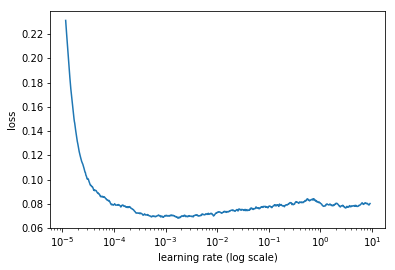

In [293]:
learner.sched.plot()

A learning rate of 10-3 seems like a reasonable choice.

In [294]:
lr = 1e-3

### Training 1st approximation

Train the model for 3 epochs with the chosen learning rate.

In [295]:
def ROC_AUC(probs, real_values):
    probs_numpy = probs.cpu().numpy()
    real_values_numpy = real_values.cpu().numpy()
    value = roc_auc_score(real_values_numpy, probs_numpy)
    return value

In [296]:
def ROC_AUC2(probs, real_values):
    value = roc_auc_score(real_values, probs)
    return value

In [298]:
learner.fit(lr, n_cycle=2, metrics=[ROC_AUC2])

epoch      trn_loss   val_loss   ROC_AUC2                     
    0      0.068623   0.068806   0.741882  
    1      0.068821   0.068982   0.740356                     



[array([0.06898]), 0.7403564557943926]

In [167]:
val_probabilities = learner.predict(is_test=False)

In [107]:
val_predictions = np.where(learner.predict(is_test=False) > 0.05, 1, 0)

In [108]:
print(classification_report(data.val_y, val_predictions))

             precision    recall  f1-score   support

        0.0       0.95      0.27      0.42     56550
        1.0       0.09      0.84      0.17      4953

avg / total       0.88      0.32      0.40     61503



In [109]:
roc_curve(data.val_y, val_probabilities)

(array([0.     , 0.00002, 0.00012, ..., 0.9995 , 0.9995 , 1.     ]),
 array([0.    , 0.    , 0.    , ..., 0.9998, 1.    , 1.    ]),
 array([1.21622, 0.21622, 0.20698, ..., 0.00149, 0.00145, 0.     ], dtype=float32))

In [ ]:
def auc_roc

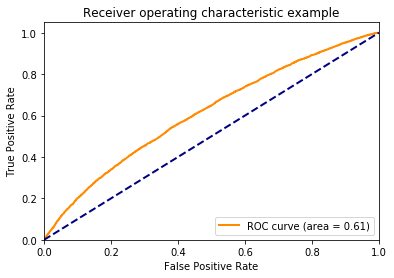

In [168]:
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr["micro"], tpr["micro"], _ = roc_curve(data.val_y, val_probabilities)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#Plot of a ROC curve for a specific class
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [169]:
roc_auc_score(data.val_y, val_probabilities)

0.6123669192442559

In [ ]:
roc_auc_score(real_values.cpu().numpy(), probs.cpu().numpy())

<br>
<br>
<a id="model_predictions"> </a>
# 6. Model predictions

<br>
## 6.1 Making the test set predictions

Set the is_test flag to True to tell the model to predict on the test set.<br>

In [82]:
test_predictions_array = learner.predict(is_test=True)

In [83]:
test_item_id

0        100001
1        100005
2        100013
3        100028
4        100038
5        100042
6        100057
7        100065
8        100066
9        100067
10       100074
11       100090
12       100091
13       100092
14       100106
15       100107
16       100109
17       100117
18       100128
19       100141
20       100150
21       100168
22       100169
23       100170
24       100171
25       100172
26       100184
27       100187
28       100212
29       100222
          ...  
48714    455963
48715    455965
48716    456007
48717    456008
48718    456009
48719    456010
48720    456011
48721    456013
48722    456028
48723    456058
48724    456111
48725    456114
48726    456115
48727    456116
48728    456119
48729    456120
48730    456122
48731    456123
48732    456166
48733    456167
48734    456168
48735    456169
48736    456170
48737    456189
48738    456202
48739    456221
48740    456222
48741    456223
48742    456224
48743    456250
Name: SK_ID_CURR, Length

In [84]:
test_item_id["item_id"].count()

KeyError: 'item_id'

It will predict the probabilities for all the rows in our dataset

In [ ]:
np.shape(test_predictions)

Check the output dimension is correct. The number of items_id of the test set should be equal to the predictions.

In [85]:
if np.shape(test_predictions)[0] == test_df["item_id"].count():
    print("Output dimension correct")
else:
    print("FATAL ERROR, output dimension doesn't match the number items")

NameError: name 'test_predictions' is not defined

In [86]:
data.test_ds.cats[0:13]

array([[ 1,  1,  1,  2,  1,  7,  7,  2,  2,  2,  2,  2,  1,  2,  1,  2,  0,  6, 19, 29],
       [ 1,  2,  1,  2,  1,  7,  7,  5,  2,  2,  2,  2,  1,  2,  1,  1, 10,  1, 10, 43],
       [ 1,  2,  2,  2,  1,  0,  7,  2,  2,  2,  2,  2,  1,  2,  1,  1,  5,  2, 15, 55],
       [ 1,  1,  1,  2,  3,  7,  7,  5,  2,  2,  2,  2,  1,  2,  2,  1, 15,  7, 12,  6],
       [ 1,  2,  2,  1,  2,  7,  7,  5,  2,  2,  2,  2,  2,  2,  1,  1,  0,  1,  6,  6],
       [ 1,  1,  2,  2,  1,  7,  4,  5,  2,  2,  2,  2,  1,  2,  2,  1,  5,  2, 16, 12],
       [ 1,  2,  2,  2,  3,  7,  7,  2,  2,  2,  2,  2,  1,  2,  1,  1,  7,  5, 10, 27],
       [ 1,  2,  1,  2,  1,  7,  7,  2,  4,  6,  2,  2,  2,  2,  2,  1,  4,  1,  8, 43],
       [ 1,  1,  1,  2,  1,  7,  4,  2,  2,  2,  2,  2,  1,  2,  1,  1,  4,  5, 19, 40],
       [ 1,  1,  2,  2,  2,  2,  7,  2,  1,  2,  2,  2,  2,  2,  2,  1, 15,  6, 15, 47],
       [ 1,  1,  1,  2,  1,  7,  3,  5,  2,  2,  2,  1,  1,  2,  2,  1,  0,  6, 12, 58],
       [ 1,  1,  1,  

In [87]:
processed_test_df.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_ANNUITY_na,AMT_GOODS_PRICE_na,OWN_CAR_AGE_na,CNT_FAM_MEMBERS_na,EXT_SOURCE_1_na,EXT_SOURCE_2_na,EXT_SOURCE_3_na
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1,1,1,2,1,7,7,2,2,2,...,1.781131,1.441565,-2.038370,-0.006247,-0.030081,0.717888,-0.00255,-1.136918,-0.046378,-0.497269
100005,1,2,1,2,1,7,7,5,2,2,...,0.435266,-1.167540,-0.473478,-0.006247,-0.030081,0.717888,-0.00255,-1.136918,-0.046378,-0.497269
100013,1,2,2,2,1,0,7,2,2,2,...,0.012103,0.970733,0.545375,-0.006247,-0.030081,-1.392976,-0.00255,0.879571,-0.046378,-0.497269
100028,1,1,1,2,3,7,7,5,2,2,...,0.153673,-0.025286,0.555178,-0.006247,-0.030081,0.717888,-0.00255,-1.136918,-0.046378,-0.497269
100038,1,2,2,1,2,7,7,5,2,2,...,-2.167493,-0.465323,0.112062,-0.006247,-0.030081,-1.392976,-0.00255,-1.136918,-0.046378,2.010984


<br>
## 6.2 Submission

###  Format

The format of the csv submission file for the avito kaggle challenge: <br><br>
    item_id,deal_probability<br>
    2,0<br>
    5,0<br>
    6,0<br>

###  Item id dataframe
We use the test_item_id dataframe from the sorted test df.

In [88]:
item_id_df = test_item_id
#item_id_df = test_item_id.reset_index().drop(['activation_date'], axis=1)

In [89]:
item_id_df.head()

0    100001
1    100005
2    100013
3    100028
4    100038
Name: SK_ID_CURR, dtype: int64

###  Test predictions dataframe
We use the predicitions array to build the dataframe

In [90]:
test_predictions_df  = pd.DataFrame(test_predictions_array, columns=['TARGET'])

In [91]:
#test_predictions_df = test_predictions_df.clip(0,1)

In [92]:
test_predictions_df.head()

,TARGET
0,0.070715
1,0.175996
2,0.035918
3,0.023198
4,0.153396


###  Submission dataframe
Concat both dataframes to generate the submission dataframe

In [93]:
submission_df = pd.concat([item_id_df, test_predictions_df], axis=1)

In [94]:
submission_df

,SK_ID_CURR,TARGET
0,100001,0.070715
1,100005,0.175996
2,100013,0.035918
3,100028,0.023198
4,100038,0.153396
5,100042,0.050149
6,100057,0.008147
7,100065,0.045495
8,100066,0.008310
9,100067,0.094229


<br>
### Submission csv file

Define the submission name and path.

In [95]:
submission_filename = "submission3"
submission_path = f"{INPUT_PATH}{s}submission{s}{submission_filename}.csv"

Create the submission file without the index column.

In [96]:
submission_df.to_csv(submission_path,index=False)

Generate a link to a direct download of the submission file.

In [111]:
FileLink(submission_path)

C:\Users\David\Desktop\Kaggle\avito\structured\input\submission\submission5.csv

Visualize sample submission.

In [90]:
sample_submission_df = pd.read_csv(f"{INPUT_PATH}{s}submission{s}sample_submission.csv")

In [91]:
sample_submission_df

,item_id,deal_probability
0,6544e41a8817,0.5
1,65b9484d670f,0.5
2,8bab230b2ecd,0.5
3,8e348601fefc,0.5
4,8bd2fe400b89,0.5
5,c63dbd6c657f,0.5
6,6d1a410df86e,0.5
7,e8d3e7922b80,0.5
8,2bc1ab208462,0.5
9,7e05d77a9181,0.5


In [ ]:
0.6
0.63